In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 832)
(466039, 1)
validation
(80707, 832)
(80707, 1)
test
(46831, 832)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:10 - loss: 0.1590 - STD: 2.0510e-04 - MAE: 0.3836

 4/47 [=>............................] - ETA: 1s - loss: 0.0564 - STD: 4.0281e-04 - MAE: 0.1843  

 7/47 [===>..........................] - ETA: 0s - loss: 0.0444 - STD: 2.8461e-04 - MAE: 0.1607

10/47 [=====>........................] - ETA: 0s - loss: 0.0409 - STD: 2.1233e-04 - MAE: 0.1557

13/47 [=======>......................] - ETA: 0s - loss: 0.0387 - STD: 1.6865e-04 - MAE: 0.1520

16/47 [=========>....................] - ETA: 0s - loss: 0.0363 - STD: 1.4366e-04 - MAE: 0.1463

19/47 [===========>..................] - ETA: 0s - loss: 0.0335 - STD: 1.2962e-04 - MAE: 0.1387

22/47 [=============>................] - ETA: 0s - loss: 0.0307 - STD: 1.2030e-04 - MAE: 0.1315

25/47 [==============>...............] - ETA: 0s - loss: 0.0287 - STD: 1.1260e-04 - MAE: 0.1275

28/47 [================>.............] - ETA: 0s - loss: 0.0274 - STD: 1.0543e-04 - MAE: 0.1255

31/47 [==================>...........] - ETA: 0s - loss: 0.0261 - STD: 9.8534e-05 - MAE: 0.1229

34/47 [====================>.........] - ETA: 0s - loss: 0.0249 - STD: 9.2536e-05 - MAE: 0.1199

37/47 [======================>.......] - ETA: 0s - loss: 0.0239 - STD: 8.7641e-05 - MAE: 0.1170

39/47 [=======================>......] - ETA: 0s - loss: 0.0235 - STD: 8.4894e-05 - MAE: 0.1154

42/47 [=========================>....] - ETA: 0s - loss: 0.0228 - STD: 8.1405e-05 - MAE: 0.1133

45/47 [===========================>..] - ETA: 0s - loss: 0.0221 - STD: 7.8585e-05 - MAE: 0.1115

47/47 [==============================] - 4s 56ms/step - loss: 0.0217 - STD: 7.7027e-05 - MAE: 0.1104 - val_loss: 0.0116 - val_STD: 3.7242e-05 - val_MAE: 0.0817


Epoch 2/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0125 - STD: 4.3695e-05 - MAE: 0.0886

 4/47 [=>............................] - ETA: 1s - loss: 0.0126 - STD: 4.4986e-05 - MAE: 0.0895

 7/47 [===>..........................] - ETA: 0s - loss: 0.0127 - STD: 4.6784e-05 - MAE: 0.0901

10/47 [=====>........................] - ETA: 0s - loss: 0.0127 - STD: 4.8494e-05 - MAE: 0.0897

13/47 [=======>......................] - ETA: 0s - loss: 0.0127 - STD: 5.0104e-05 - MAE: 0.0892

16/47 [=========>....................] - ETA: 0s - loss: 0.0127 - STD: 5.1846e-05 - MAE: 0.0886

19/47 [===========>..................] - ETA: 0s - loss: 0.0127 - STD: 5.3672e-05 - MAE: 0.0883

22/47 [=============>................] - ETA: 0s - loss: 0.0127 - STD: 5.5682e-05 - MAE: 0.0881

25/47 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 5.7929e-05 - MAE: 0.0881

28/47 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 6.0250e-05 - MAE: 0.0882

31/47 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 6.2746e-05 - MAE: 0.0882

34/47 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 6.5327e-05 - MAE: 0.0882

37/47 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 6.8036e-05 - MAE: 0.0881

40/47 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 7.0869e-05 - MAE: 0.0880

43/47 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 7.3929e-05 - MAE: 0.0879

46/47 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 7.7257e-05 - MAE: 0.0879

47/47 [==============================] - 1s 28ms/step - loss: 0.0126 - STD: 7.8402e-05 - MAE: 0.0878 - val_loss: 0.0115 - val_STD: 1.1427e-04 - val_MAE: 0.0806


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0128 - STD: 1.3564e-04 - MAE: 0.0882

 4/47 [=>............................] - ETA: 1s - loss: 0.0125 - STD: 1.4120e-04 - MAE: 0.0873

 7/47 [===>..........................] - ETA: 0s - loss: 0.0125 - STD: 1.4729e-04 - MAE: 0.0875

10/47 [=====>........................] - ETA: 0s - loss: 0.0126 - STD: 1.5401e-04 - MAE: 0.0877

13/47 [=======>......................] - ETA: 0s - loss: 0.0126 - STD: 1.6143e-04 - MAE: 0.0877

16/47 [=========>....................] - ETA: 0s - loss: 0.0127 - STD: 1.6956e-04 - MAE: 0.0878

19/47 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 1.7845e-04 - MAE: 0.0876

22/47 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 1.8804e-04 - MAE: 0.0875

25/47 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 1.9847e-04 - MAE: 0.0875

28/47 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 2.0994e-04 - MAE: 0.0874

31/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 2.2251e-04 - MAE: 0.0873

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 2.3647e-04 - MAE: 0.0873

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 2.5184e-04 - MAE: 0.0873

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 2.6898e-04 - MAE: 0.0874

43/47 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 2.8795e-04 - MAE: 0.0874

45/47 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 3.0185e-04 - MAE: 0.0874

47/47 [==============================] - 1s 28ms/step - loss: 0.0126 - STD: 3.1653e-04 - MAE: 0.0874 - val_loss: 0.0114 - val_STD: 5.8703e-04 - val_MAE: 0.0803


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0126 - STD: 6.9501e-04 - MAE: 0.0874

 4/47 [=>............................] - ETA: 1s - loss: 0.0125 - STD: 7.4367e-04 - MAE: 0.0871

 7/47 [===>..........................] - ETA: 0s - loss: 0.0125 - STD: 7.9822e-04 - MAE: 0.0871

 9/47 [====>.........................] - ETA: 0s - loss: 0.0125 - STD: 8.3883e-04 - MAE: 0.0872

12/47 [======>.......................] - ETA: 0s - loss: 0.0125 - STD: 9.0841e-04 - MAE: 0.0872

15/47 [========>.....................] - ETA: 0s - loss: 0.0125 - STD: 9.8402e-04 - MAE: 0.0872

18/47 [==========>...................] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0870    

21/47 [============>.................] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0870

24/47 [==============>...............] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0871

27/47 [================>.............] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0870

30/47 [==================>...........] - ETA: 0s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0870

33/47 [====================>.........] - ETA: 0s - loss: 0.0124 - STD: 0.0017 - MAE: 0.0869

36/47 [=====================>........] - ETA: 0s - loss: 0.0124 - STD: 0.0019 - MAE: 0.0869

39/47 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0868

42/47 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0867

45/47 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.0026 - MAE: 0.0867

47/47 [==============================] - 1s 28ms/step - loss: 0.0123 - STD: 0.0028 - MAE: 0.0867 - val_loss: 0.0108 - val_STD: 0.0068 - val_MAE: 0.0781


Epoch 5/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0115 - STD: 0.0080 - MAE: 0.0845

 3/47 [>.............................] - ETA: 1s - loss: 0.0114 - STD: 0.0084 - MAE: 0.0842

 6/47 [==>...........................] - ETA: 0s - loss: 0.0117 - STD: 0.0091 - MAE: 0.0847

 9/47 [====>.........................] - ETA: 0s - loss: 0.0116 - STD: 0.0099 - MAE: 0.0846

12/47 [======>.......................] - ETA: 0s - loss: 0.0116 - STD: 0.0109 - MAE: 0.0845

15/47 [========>.....................] - ETA: 0s - loss: 0.0115 - STD: 0.0119 - MAE: 0.0842

18/47 [==========>...................] - ETA: 0s - loss: 0.0114 - STD: 0.0129 - MAE: 0.0839

21/47 [============>.................] - ETA: 0s - loss: 0.0114 - STD: 0.0140 - MAE: 0.0836

24/47 [==============>...............] - ETA: 0s - loss: 0.0113 - STD: 0.0152 - MAE: 0.0835

27/47 [================>.............] - ETA: 0s - loss: 0.0113 - STD: 0.0164 - MAE: 0.0832

30/47 [==================>...........] - ETA: 0s - loss: 0.0112 - STD: 0.0177 - MAE: 0.0829

33/47 [====================>.........] - ETA: 0s - loss: 0.0111 - STD: 0.0190 - MAE: 0.0827

36/47 [=====================>........] - ETA: 0s - loss: 0.0111 - STD: 0.0203 - MAE: 0.0824

39/47 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.0215 - MAE: 0.0821

42/47 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 0.0227 - MAE: 0.0818

45/47 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 0.0239 - MAE: 0.0816

47/47 [==============================] - 1s 28ms/step - loss: 0.0109 - STD: 0.0247 - MAE: 0.0815 - val_loss: 0.0088 - val_STD: 0.0360 - val_MAE: 0.0701


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0097 - STD: 0.0425 - MAE: 0.0761

 4/47 [=>............................] - ETA: 1s - loss: 0.0098 - STD: 0.0430 - MAE: 0.0768

 7/47 [===>..........................] - ETA: 0s - loss: 0.0097 - STD: 0.0434 - MAE: 0.0764

10/47 [=====>........................] - ETA: 0s - loss: 0.0096 - STD: 0.0438 - MAE: 0.0760

13/47 [=======>......................] - ETA: 0s - loss: 0.0096 - STD: 0.0442 - MAE: 0.0758

16/47 [=========>....................] - ETA: 0s - loss: 0.0095 - STD: 0.0445 - MAE: 0.0754

19/47 [===========>..................] - ETA: 0s - loss: 0.0094 - STD: 0.0450 - MAE: 0.0751

22/47 [=============>................] - ETA: 0s - loss: 0.0094 - STD: 0.0455 - MAE: 0.0749

25/47 [==============>...............] - ETA: 0s - loss: 0.0093 - STD: 0.0460 - MAE: 0.0744

27/47 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 0.0465 - MAE: 0.0742

30/47 [==================>...........] - ETA: 0s - loss: 0.0091 - STD: 0.0472 - MAE: 0.0737

33/47 [====================>.........] - ETA: 0s - loss: 0.0090 - STD: 0.0481 - MAE: 0.0733

35/47 [=====================>........] - ETA: 0s - loss: 0.0089 - STD: 0.0486 - MAE: 0.0730

38/47 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0495 - MAE: 0.0725

41/47 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.0505 - MAE: 0.0722

44/47 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0514 - MAE: 0.0718

47/47 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0523 - MAE: 0.0714

47/47 [==============================] - 1s 28ms/step - loss: 0.0086 - STD: 0.0523 - MAE: 0.0714 - val_loss: 0.0068 - val_STD: 0.0583 - val_MAE: 0.0622


Epoch 7/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0071 - STD: 0.0637 - MAE: 0.0635

 4/47 [=>............................] - ETA: 1s - loss: 0.0073 - STD: 0.0658 - MAE: 0.0649

 7/47 [===>..........................] - ETA: 0s - loss: 0.0073 - STD: 0.0666 - MAE: 0.0648

10/47 [=====>........................] - ETA: 0s - loss: 0.0073 - STD: 0.0673 - MAE: 0.0645

13/47 [=======>......................] - ETA: 0s - loss: 0.0072 - STD: 0.0675 - MAE: 0.0643

16/47 [=========>....................] - ETA: 0s - loss: 0.0072 - STD: 0.0677 - MAE: 0.0642

19/47 [===========>..................] - ETA: 0s - loss: 0.0072 - STD: 0.0678 - MAE: 0.0641

22/47 [=============>................] - ETA: 0s - loss: 0.0072 - STD: 0.0680 - MAE: 0.0641

24/47 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.0681 - MAE: 0.0641

27/47 [================>.............] - ETA: 0s - loss: 0.0072 - STD: 0.0683 - MAE: 0.0641

30/47 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0684 - MAE: 0.0639

33/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0686 - MAE: 0.0637

36/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0688 - MAE: 0.0636

39/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0691 - MAE: 0.0634

42/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0693 - MAE: 0.0633

45/47 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0696 - MAE: 0.0632

47/47 [==============================] - 1s 28ms/step - loss: 0.0070 - STD: 0.0697 - MAE: 0.0631 - val_loss: 0.0064 - val_STD: 0.0654 - val_MAE: 0.0597


Epoch 8/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0719 - MAE: 0.0607

 4/47 [=>............................] - ETA: 1s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0610

 7/47 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0717 - MAE: 0.0607

10/47 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0605

13/47 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0725 - MAE: 0.0604

16/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0605

19/47 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0604

22/47 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0604

25/47 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0732 - MAE: 0.0604

28/47 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0603

30/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0603

32/47 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0604

35/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0603

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0602

41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0603

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0603

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0603

47/47 [==============================] - 1s 28ms/step - loss: 0.0065 - STD: 0.0737 - MAE: 0.0603 - val_loss: 0.0059 - val_STD: 0.0663 - val_MAE: 0.0567


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0736 - MAE: 0.0584

 4/47 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0750 - MAE: 0.0591

 7/47 [===>..........................] - ETA: 0s - loss: 0.0064 - STD: 0.0762 - MAE: 0.0594

10/47 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0763 - MAE: 0.0592

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0763 - MAE: 0.0592

16/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0761 - MAE: 0.0590

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0760 - MAE: 0.0589

22/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0759 - MAE: 0.0587

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0759 - MAE: 0.0587

28/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0760 - MAE: 0.0585

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0762 - MAE: 0.0585

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0763 - MAE: 0.0585

37/47 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0584

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0765 - MAE: 0.0583

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0766 - MAE: 0.0583

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0767 - MAE: 0.0582

47/47 [==============================] - 1s 28ms/step - loss: 0.0062 - STD: 0.0766 - MAE: 0.0581 - val_loss: 0.0058 - val_STD: 0.0695 - val_MAE: 0.0559


Epoch 10/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0770 - MAE: 0.0574

 4/47 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0779 - MAE: 0.0572

 7/47 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0785 - MAE: 0.0572

10/47 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0790 - MAE: 0.0568

13/47 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0790 - MAE: 0.0566

16/47 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0789 - MAE: 0.0566

19/47 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0790 - MAE: 0.0566

22/47 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0788 - MAE: 0.0565

25/47 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0789 - MAE: 0.0564

28/47 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0790 - MAE: 0.0563

31/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0790 - MAE: 0.0563

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0791 - MAE: 0.0564

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0792 - MAE: 0.0563

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0793 - MAE: 0.0562

43/47 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0794 - MAE: 0.0561

46/47 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0795 - MAE: 0.0560

47/47 [==============================] - 1s 28ms/step - loss: 0.0058 - STD: 0.0796 - MAE: 0.0560 - val_loss: 0.0055 - val_STD: 0.0721 - val_MAE: 0.0541


Epoch 11/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0792 - MAE: 0.0540

 4/47 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0797 - MAE: 0.0549

 7/47 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0807 - MAE: 0.0566

10/47 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0566

13/47 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0802 - MAE: 0.0567

16/47 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0796 - MAE: 0.0565

18/47 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0798 - MAE: 0.0565

21/47 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0799 - MAE: 0.0564

24/47 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0802 - MAE: 0.0563

27/47 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0803 - MAE: 0.0563

30/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0801 - MAE: 0.0564

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0796 - MAE: 0.0564

35/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0793 - MAE: 0.0567

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0791 - MAE: 0.0568

41/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0792 - MAE: 0.0568

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0792 - MAE: 0.0567

47/47 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0792 - MAE: 0.0567

47/47 [==============================] - 1s 28ms/step - loss: 0.0060 - STD: 0.0792 - MAE: 0.0567 - val_loss: 0.0058 - val_STD: 0.0748 - val_MAE: 0.0561


Epoch 12/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0566

 4/47 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0802 - MAE: 0.0557

 7/47 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0798 - MAE: 0.0551

10/47 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0799 - MAE: 0.0551

13/47 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0550

16/47 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0809 - MAE: 0.0550

19/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0810 - MAE: 0.0549

22/47 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0812 - MAE: 0.0548

25/47 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0813 - MAE: 0.0546

28/47 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0814 - MAE: 0.0546

31/47 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0814 - MAE: 0.0544

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0815 - MAE: 0.0544

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0816 - MAE: 0.0544

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0817 - MAE: 0.0543

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0543

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0820 - MAE: 0.0542

47/47 [==============================] - 1s 28ms/step - loss: 0.0055 - STD: 0.0821 - MAE: 0.0542 - val_loss: 0.0055 - val_STD: 0.0753 - val_MAE: 0.0536


Epoch 13/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0831 - MAE: 0.0530

 3/47 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0532

 6/47 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0825 - MAE: 0.0537

 9/47 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0828 - MAE: 0.0538

12/47 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0831 - MAE: 0.0538

15/47 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0538

18/47 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0831 - MAE: 0.0538

21/47 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0830 - MAE: 0.0539

24/47 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0830 - MAE: 0.0538

27/47 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0829 - MAE: 0.0538

30/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0829 - MAE: 0.0537

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0537

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0831 - MAE: 0.0536

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0537

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0536

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0537

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0536

47/47 [==============================] - 1s 28ms/step - loss: 0.0054 - STD: 0.0833 - MAE: 0.0536 - val_loss: 0.0054 - val_STD: 0.0752 - val_MAE: 0.0532


Epoch 14/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0830 - MAE: 0.0532

 4/47 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0841 - MAE: 0.0526

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0837 - MAE: 0.0527

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0833 - MAE: 0.0527

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0838 - MAE: 0.0529

16/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0528

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0530

22/47 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0529

25/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0529

28/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0529

30/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0529

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0531

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0532

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0532

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0532

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0532

47/47 [==============================] - 1s 28ms/step - loss: 0.0054 - STD: 0.0840 - MAE: 0.0532 - val_loss: 0.0053 - val_STD: 0.0757 - val_MAE: 0.0530


Epoch 15/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0518

 4/47 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0849 - MAE: 0.0529

 7/47 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0850 - MAE: 0.0530

10/47 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0529

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0527

16/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0528

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0526

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0525

25/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0527

28/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0527

31/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0528

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0528

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0528

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0529

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0528

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0528

47/47 [==============================] - 1s 28ms/step - loss: 0.0053 - STD: 0.0847 - MAE: 0.0528 - val_loss: 0.0053 - val_STD: 0.0768 - val_MAE: 0.0530


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0836 - MAE: 0.0522

 4/47 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0524

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0844 - MAE: 0.0523

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0524

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0523

15/47 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0523

18/47 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0523

21/47 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

24/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

27/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0522

30/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0522

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0525

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0525

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0526

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0526

47/47 [==============================] - 1s 27ms/step - loss: 0.0053 - STD: 0.0849 - MAE: 0.0526 - val_loss: 0.0054 - val_STD: 0.0780 - val_MAE: 0.0534


Epoch 17/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0524

 3/47 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0528

 6/47 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0526

 8/47 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0527

10/47 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0527

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0527

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0526

19/47 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0524

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0524

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0524

28/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

47/47 [==============================] - 1s 27ms/step - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523 - val_loss: 0.0054 - val_STD: 0.0785 - val_MAE: 0.0533


Epoch 18/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0516

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0844 - MAE: 0.0518

 6/47 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0525

 9/47 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0527

12/47 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0526

15/47 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0527

18/47 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0526

21/47 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

24/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

27/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

29/47 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0522

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0522

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0521

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0521

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0522

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0521

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

47/47 [==============================] - 1s 28ms/step - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521 - val_loss: 0.0054 - val_STD: 0.0794 - val_MAE: 0.0531


Epoch 19/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0519

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0518

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0516

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0519

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0519

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0519

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0518

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0517

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0516

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0518

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0518

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0518

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0519

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0519

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0519

47/47 [==============================] - 1s 27ms/step - loss: 0.0051 - STD: 0.0858 - MAE: 0.0519 - val_loss: 0.0054 - val_STD: 0.0796 - val_MAE: 0.0531


Epoch 20/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0506

 4/47 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0866 - MAE: 0.0522

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0863 - MAE: 0.0523

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0860 - MAE: 0.0524

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0861 - MAE: 0.0523

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0524

19/47 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0523

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

28/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0520

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0519

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0520

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0519

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0519

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0518

47/47 [==============================] - 1s 27ms/step - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518 - val_loss: 0.0055 - val_STD: 0.0808 - val_MAE: 0.0535


Epoch 21/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0050 - STD: 0.0876 - MAE: 0.0517

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0865 - MAE: 0.0517

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0865 - MAE: 0.0516

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0869 - MAE: 0.0513

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0512

16/47 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0512

19/47 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0511

22/47 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0511

25/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0510

28/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0512

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0512

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0512

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0513

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0513

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0513

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0512

47/47 [==============================] - 1s 27ms/step - loss: 0.0050 - STD: 0.0866 - MAE: 0.0512 - val_loss: 0.0054 - val_STD: 0.0797 - val_MAE: 0.0530


Epoch 22/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0881 - MAE: 0.0504

 4/47 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0880 - MAE: 0.0522

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0872 - MAE: 0.0520

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0867 - MAE: 0.0519

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0862 - MAE: 0.0519

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0863 - MAE: 0.0520

19/47 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0861 - MAE: 0.0519

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0518

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0517

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0517

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0517

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0516

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0515

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0514

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0514

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0514

47/47 [==============================] - 1s 27ms/step - loss: 0.0051 - STD: 0.0863 - MAE: 0.0513 - val_loss: 0.0056 - val_STD: 0.0834 - val_MAE: 0.0540


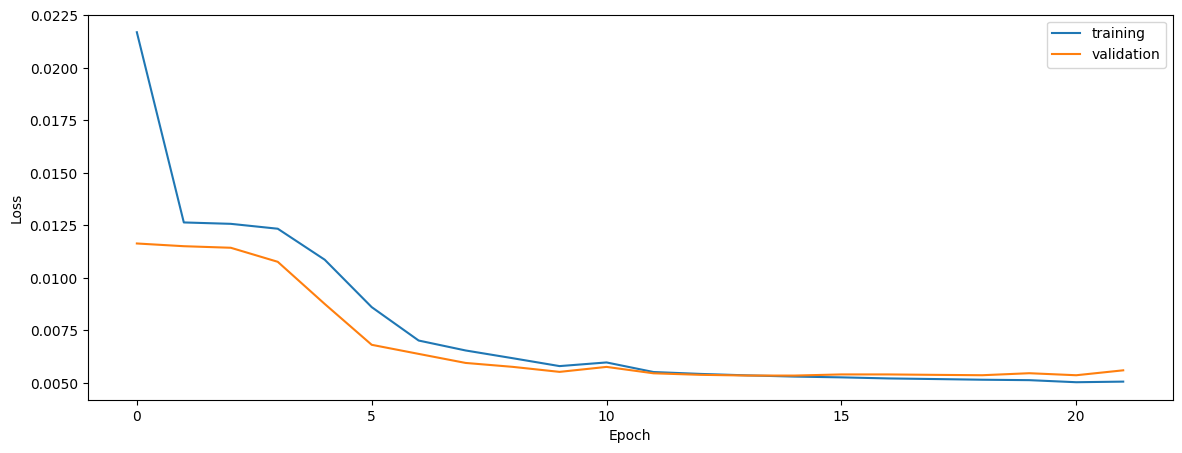

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7680198485088042
0.7329540960325891
0.7663194750046657


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7680198485088042
0.7329540960325891
0.7663194750046657


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7701270888072408
0.7467697102114397
0.752494858999231


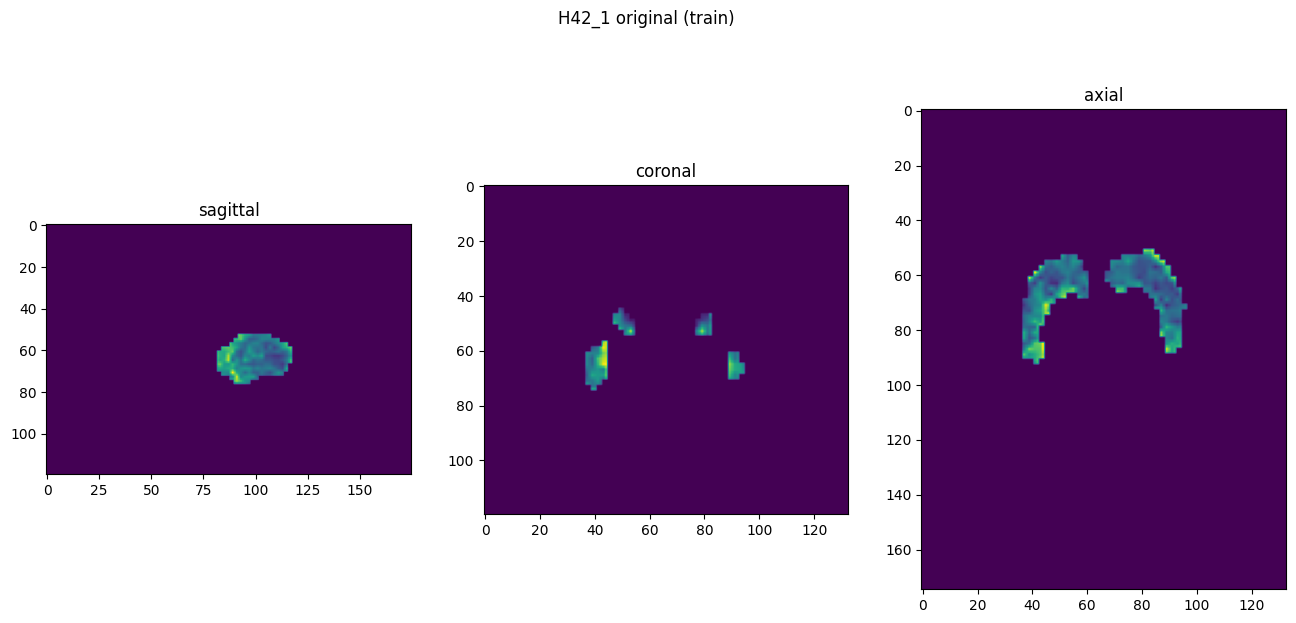

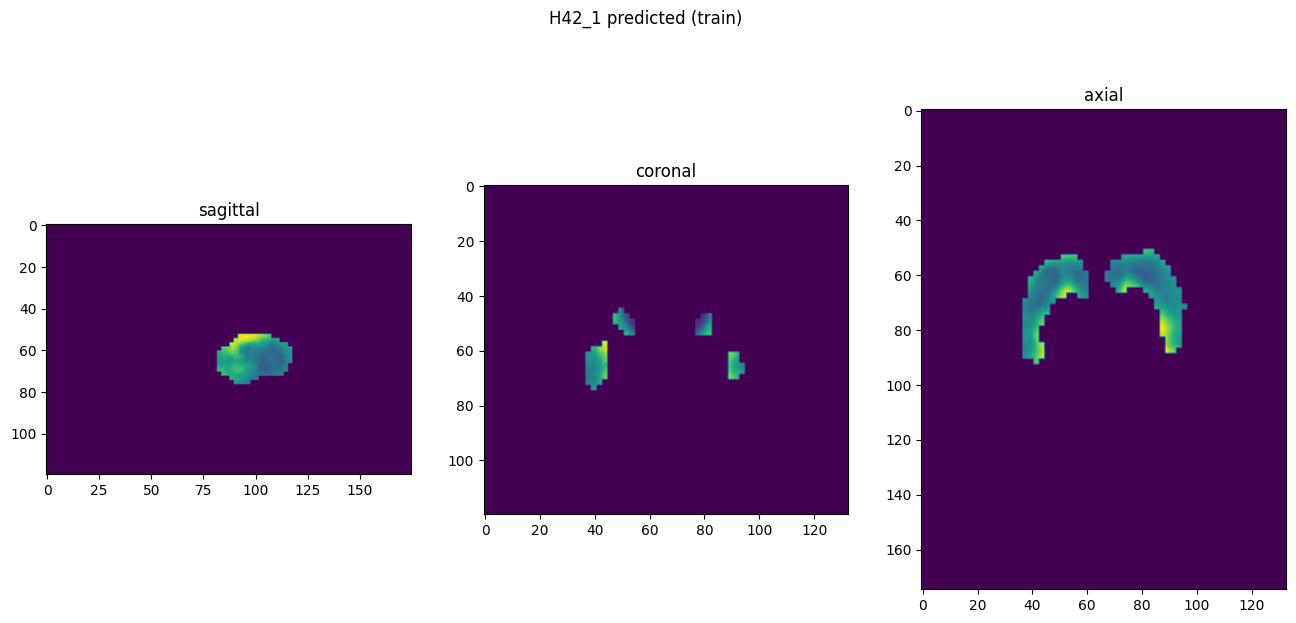

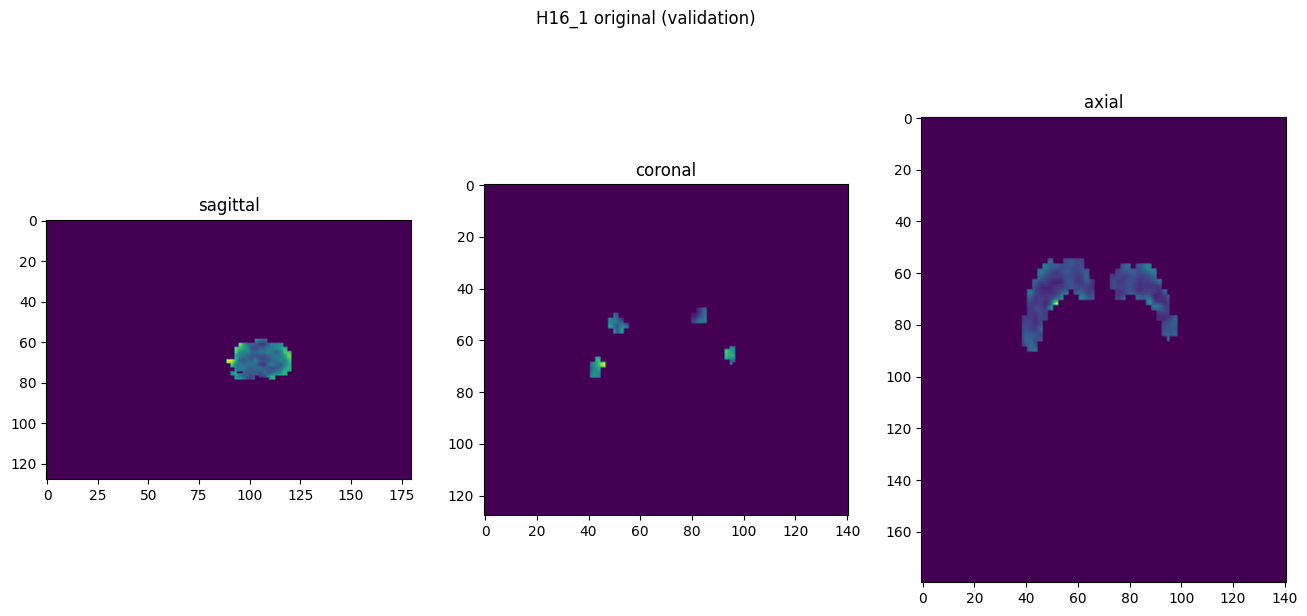

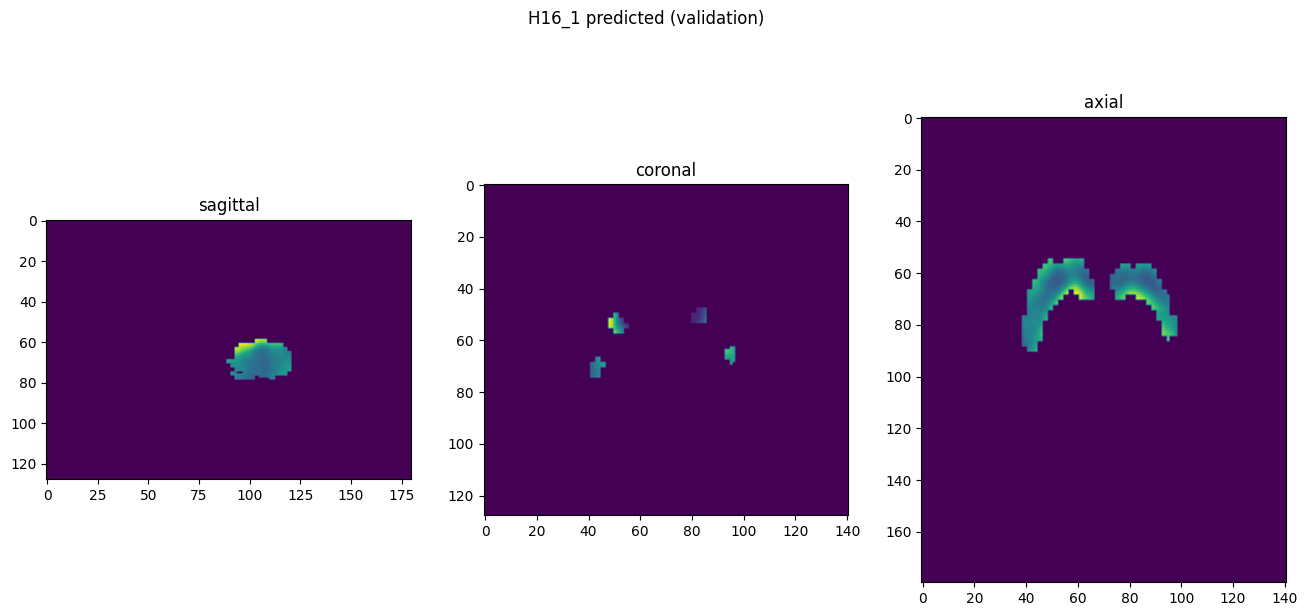

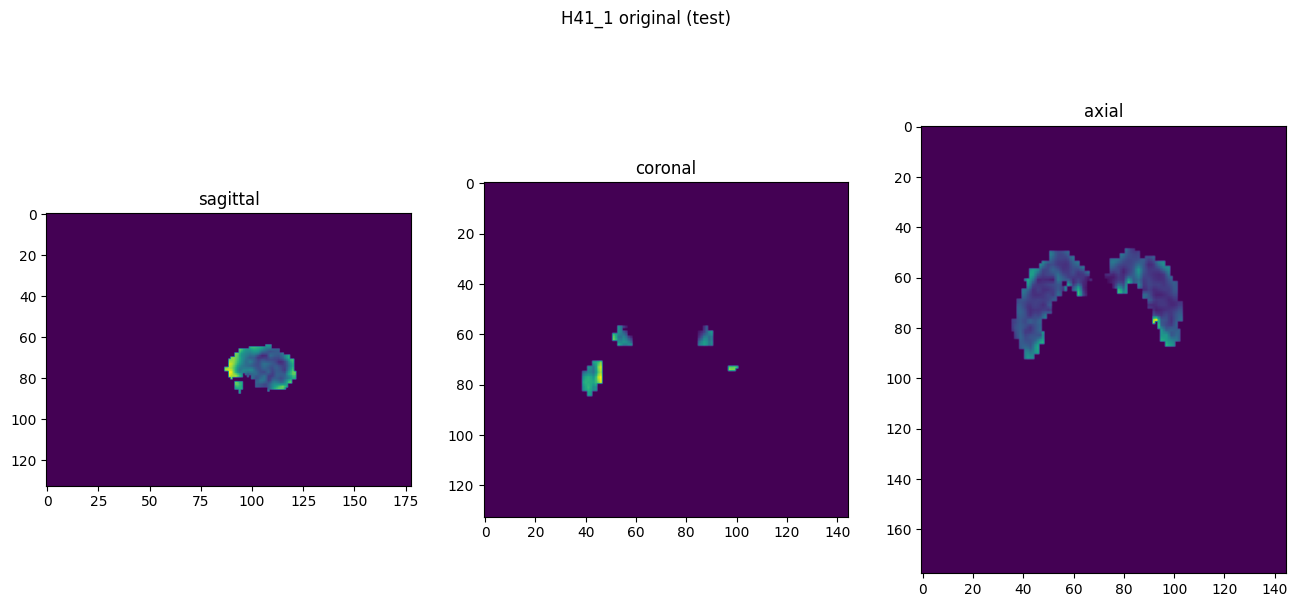

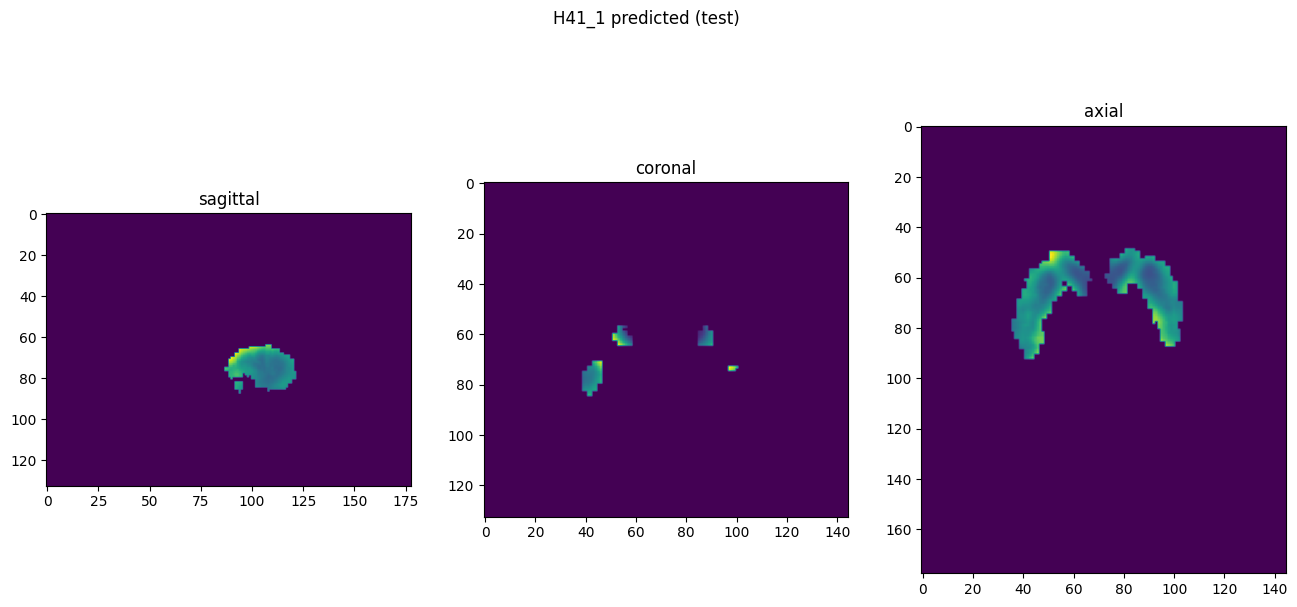

In [10]:
showResults(model, gen, threshold=None, background=False)